# Import packages

In [1]:
import pandas as pd
import numpy as np
from boosted_decision_tree import *
from significance import *
from HPO import *
from feature_engineering import *
from HiggsML.datasets import BlackSwan_public_dataset as public_dataset
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import ensemble
import pickle
import copy

# Prepare the data

### Import the data

In [2]:
data=public_dataset()
data.load_train_set()
data_set=data.get_train_set()
data_set_der=copy.deepcopy(data_set)

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5090511 entries, 0 to 5090510
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 310.7 MB
None
[*] Train data loaded successfully


In [3]:
len(data_set["data"].columns)

16

### Split data

In [4]:
train_set, test_set= train_test_split(data_set,test_size=0.2, random_state=42,reweight=True)
training_data, train_weights, y_train=train_set["data"], train_set["weights"], train_set["labels"]
valid_data, valid_weights, y_test=test_set["data"], test_set["weights"], test_set["labels"]

### Get the data with derived features

In [5]:
data_set_der['data']=feature_engineering(data_set_der['data'])
train_set_der, test_set_der= train_test_split(data_set_der,test_size=0.2, random_state=42,reweight=True)
training_data_der, valid_data_der=train_set_der["data"],test_set_der["data"]

feature engineering took 5.42 s, results:

         PRI_lep_pt   PRI_lep_eta   PRI_lep_phi    PRI_had_pt   PRI_had_eta  \
count  5.090511e+06  5.090511e+06  5.090511e+06  5.090511e+06  5.090511e+06   
mean   4.003698e+01  3.925515e-04  1.407315e-03  5.060483e+01 -2.050461e-04   
std    2.381429e+01  1.170707e+00  1.810495e+00  2.750230e+01  1.201028e+00   
min    2.000000e+01 -2.500000e+00 -3.142000e+00  2.285000e+01 -2.688000e+00   
25%    2.583500e+01 -8.910000e-01 -1.569000e+00  3.388800e+01 -9.250000e-01   
50%    3.331800e+01  0.000000e+00  2.000000e-03  4.432600e+01 -1.000000e-03   
75%    4.544000e+01  8.930000e-01  1.573000e+00  5.823900e+01  9.250000e-01   
max    1.261630e+03  2.500000e+00  3.142000e+00  1.260630e+03  2.728000e+00   

        PRI_had_phi  PRI_jet_leading_pt  PRI_jet_leading_eta  \
count  5.090511e+06        5.090511e+06         5.090511e+06   
mean   4.544730e-05        7.441782e+01        -4.562408e-04   
std    1.809866e+00        5.820190e+01         1.544

### Balance weights

In [6]:
class_weights_train = (
           train_weights[y_train == 0].sum(),
            train_weights[y_train == 1].sum(),
        )
train_weights[y_train == 0] *= (
                max(class_weights_train) / class_weights_train[0])
train_weights[y_train == 1] *= (
                max(class_weights_train) / class_weights_train[1])

# Fit the models

### Initialize models

In [7]:
classifiers["XGBoost"]=XGBClassifier()
classifiers['lightgbm']=lgb.LGBMClassifier()
classifiers['sklearnbdt']=ensemble.HistGradientBoostingClassifier()

In [8]:
xgb=BoostedDecisionTree(train_set,classifier="XGBoost")
lgb_model=BoostedDecisionTree(train_set,classifier="lightgbm")
skgb=BoostedDecisionTree(train_set,classifier="sklearnbdt")

### Initialize models for derived features

In [9]:
xgb_der=copy.deepcopy(BoostedDecisionTree(train_set_der,classifier="XGBoost"))
lgb_model_der=copy.deepcopy(BoostedDecisionTree(train_set_der,classifier="lightgbm"))
skgb_der=copy.deepcopy(BoostedDecisionTree(train_set_der,classifier="sklearnbdt"))

### Fit the models

In [10]:
xgb.fit(training_data,y_train,weights=train_weights)
lgb_model.fit(training_data,y_train,weights=train_weights)
skgb.fit(training_data,y_train,weights=train_weights)

fitting XGBoost model
XGBoost model fitted in 20.38788652420044 s
fitting Lightgbm model
[LightGBM] [Info] Number of positive: 3466034, number of negative: 701983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3840
[LightGBM] [Info] Number of data points in the train set: 4168017, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Lightgbm model fitted in 18.70320177078247 s
fitting skgb model
skgb model fitted in 52.80953335762024 s


In [12]:
xgb_der.fit(training_data_der,y_train,weights=train_weights)
lgb_model_der.fit(training_data_der,y_train,weights=train_weights)
skgb_der.fit(training_data_der,y_train,weights=train_weights)

fitting XGBoost model
XGBoost model fitted in 22.673629999160767 s
fitting Lightgbm model
[LightGBM] [Info] Number of positive: 3466034, number of negative: 701983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6888
[LightGBM] [Info] Number of data points in the train set: 4168017, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Lightgbm model fitted in 19.903829336166382 s
fitting skgb model
skgb model fitted in 67.50903010368347 s


## Feature importance

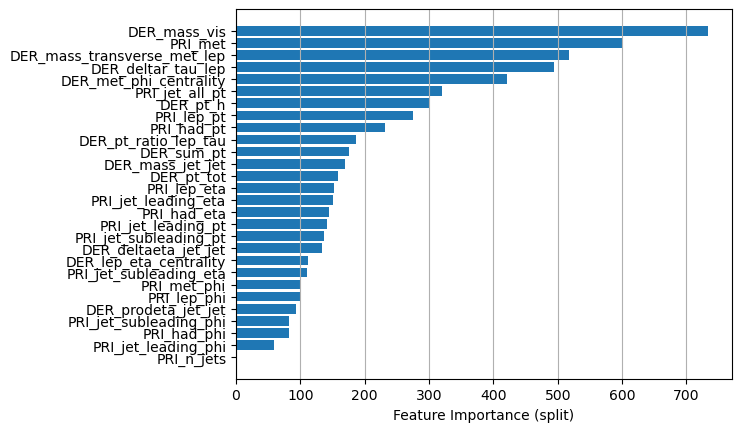

In [36]:
#Computing feature importance
def feature_importance(tree, data):
    feat_imp = tree.model.get_booster().get_fscore()
    features = data.columns
    imp_dic = {features[int(fimp[1:])]: feat_imp[fimp] for fimp in feat_imp}
    total = sum([imp_dic[k] for k in imp_dic.keys()])
    #imp_dic = {k: imp_dic[k] / total for k in imp_dic.keys()}
    return imp_dic

df_data = pd.DataFrame(data_set_der['data'])
feature_imp = feature_importance(xgb_der, df_data)
ordered_features = sorted(feature_imp, key=feature_imp.get, reverse=True)
ordered_features_barh = sorted(feature_imp, key=feature_imp.get)
ordered_importance = sorted(list(feature_imp.values()))
plt.barh(range(len(feature_imp)), ordered_importance, tick_label=ordered_features_barh)
plt.xlabel("Feature Importance (split)")
plt.grid(axis='x')

# Do predictions

## Prediction on training set

### Prediction on training set with only primary features

In [13]:
y_pred_train_xgb=xgb.predict(valid_data)
y_pred_train_lgb=lgb_model.predict(training_data)
y_pred_train_skgb=skgb.predict(training_data)

KeyboardInterrupt: 

### Prediction on training set with primary features and derived features

In [ ]:
y_pred_train_der_xgb=xgb_der.predict(training_data_der)
y_pred_train_der_lgb=lgb_model_der.predict(training_data_der)
y_pred_train_der_skgb=skgb_der.predict(training_data_der)

## Prediction on test set

### Prediction on test set with only primary features

In [ ]:
y_pred_xgb=xgb.predict(valid_data)
y_pred_lgb=lgb_model.predict(valid_data)
y_pred_skgb=skgb.predict(valid_data)

### Prediction on test set with primary features and derived features

In [ ]:
y_pred_der_xgb=xgb_der.predict(valid_data_der)
y_pred_der_lgb=lgb_model_der.predict(valid_data_der)
y_pred_der_skgb=skgb_der.predict(valid_data_der)

# Hyperparameter Optimization

### Attention: You can skip the next 4 cells and load directly the parameters because finding the optimal parameters takes a lot of time (around 17 minutes for each model)

In [ ]:
best_param_xgb=optimize_hyperparameters(training_data_der,y_train,classifier="XGBoost",sample_weights=train_weights,cv=5,n_iter=20)

Best parameters:  {'learning_rate': 0.3394981139334837, 'max_depth': 7, 'n_estimators': 256}
Best score (on train dataset CV):  0.8438642690093026


In [ ]:
best_param_lgb=optimize_hyperparameters(training_data_der,y_train,classifier="lightgbm",sample_weights=train_weights,cv=5,n_iter=20)

[LightGBM] [Info] Number of positive: 3466034, number of negative: 701983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.608700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6647
[LightGBM] [Info] Number of data points in the train set: 4168017, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
best_param_skgb=optimize_hyperparameters(training_data_der,y_train,classifier="sklearnbdt",sample_weights=train_weights,cv=5,n_iter=20)

Best parameters:  {'learning_rate': 0.22793679320154156, 'max_depth': 5, 'max_iter': 258, 'max_leaf_nodes': 127, 'min_samples_leaf': 30}
Best score (on train dataset CV):  0.8418870373757901


In [ ]:
with open(str('best_param')+'.pkl', 'wb') as file:
            pickle.dump((best_param_xgb,best_param_lgb,best_param_skgb), file)

### Loading the best parameters

In [ ]:
with open(str('best_param')+'.pkl', 'rb') as file:
        best_param_xgb,best_param_lgb,best_param_skgb= pickle.load(file)

### fitting the models with the optimal parameters and doing the predictions

In [ ]:
classifiers['XGBoost']=XGBClassifier(learning_rate=best_param_xgb["learning_rate"],max_depth=best_param_xgb["max_depth"],n_estimators=best_param_xgb["n_estimators"])
classifiers['lightgbm']=lgb.LGBMClassifier(learning_rate=best_param_lgb["learning_rate"],n_estimators=best_param_lgb['n_estimators'],max_depth=best_param_lgb["max_depth"],num_leaves=best_param_lgb["num_leaves"])
classifiers['sklearnbdt']=ensemble.HistGradientBoostingClassifier(learning_rate=best_param_skgb['learning_rate'],max_depth=best_param_skgb['max_depth'],max_iter=best_param_skgb['max_iter'],max_leaf_nodes=best_param_skgb['max_leaf_nodes'],min_samples_leaf=best_param_skgb['min_samples_leaf'])

In [ ]:
xgb_der_hpo=BoostedDecisionTree(train_set,classifier="XGBoost")
lgb_model_der_hpo=BoostedDecisionTree(train_set,classifier="lightgbm")
skgb_der_hpo=BoostedDecisionTree(train_set,classifier="sklearnbdt")

In [ ]:
xgb_der_hpo.fit(training_data_der,y_train,weights=train_weights)
lgb_model_der_hpo.fit(training_data_der,y_train,weights=train_weights)
skgb_der_hpo.fit(training_data_der,y_train,weights=train_weights)

fitting XGBoot model
XGBoost model fitted in 49.197789669036865 s
fitting Lightgbm model
[LightGBM] [Info] Number of positive: 3466034, number of negative: 701983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.467687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6648
[LightGBM] [Info] Number of data points in the train set: 4168017, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [ ]:
y_pred_train_der_hpo_xgb=xgb_der_hpo.predict(training_data_der)
y_pred_train_der_hpo_lgb=lgb_model_der_hpo.predict(training_data_der)
y_pred_train_der_hpo_skgb=skgb_der_hpo.predict(training_data_der)

In [ ]:
y_pred_der_hpo_xgb=xgb_der_hpo.predict(valid_data_der)
y_pred_der_hpo_lgb=lgb_model_der_hpo.predict(valid_data_der)
y_pred_der_hpo_skgb=skgb_der_hpo.predict(valid_data_der)

# Plotting some interesting curves

## ROC CURVE

### Effect of derived features and hyperparameter optimiztion

roc_auc_score : 0.8470757015294788
roc_auc_score : 0.8794816466103171
roc_auc_score : 0.8802746376912719


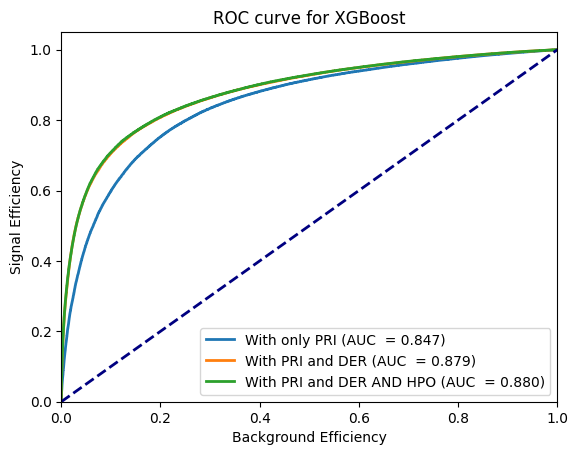

In [ ]:
fpr_xgb,tpr_xgb,roc_score_xgb=roc_curve_plot(xgb,test_set,y_pred_xgb,y_test,valid_weights)
fpr_der_xgb,tpr_der_xgb,roc_score_der_xgb=roc_curve_plot(xgb_der,test_set,y_pred_der_xgb,y_test,valid_weights)
fpr_der_hpo_xgb,tpr_der_hpo_xgb,roc_score_der_hpo_xgb=roc_curve_plot(xgb_der_hpo,test_set,y_pred_der_hpo_xgb,y_test,valid_weights)
plt.plot(fpr_xgb, tpr_xgb,lw=2, label='With only PRI (AUC  = {:.3f})'.format(roc_score_xgb))
plt.plot(fpr_der_xgb, tpr_der_xgb,lw=2, label='With PRI and DER (AUC  = {:.3f})'.format(roc_score_der_xgb))
plt.plot(fpr_der_hpo_xgb, tpr_der_hpo_xgb,lw=2, label='With PRI and DER AND HPO (AUC  = {:.3f})'.format(roc_score_der_hpo_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

roc_auc_score : 0.8347550287117526
roc_auc_score : 0.8764147063119756
roc_auc_score : 0.8801846393374358


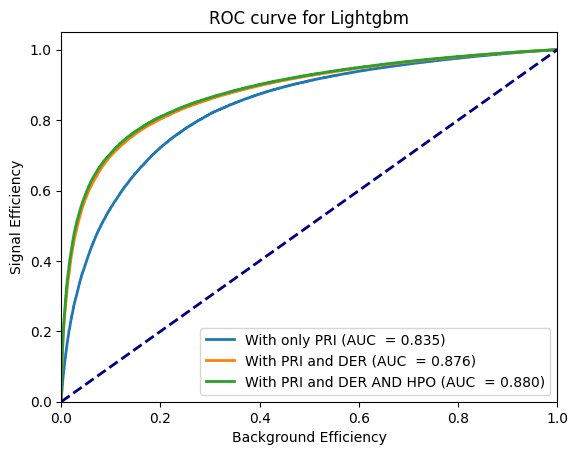

In [ ]:
fpr_lgb,tpr_lgb,roc_score_lgb=roc_curve_plot(lgb_model,test_set,y_pred_lgb,y_test,valid_weights)
fpr_der_lgb,tpr_der_lgb,roc_score_der_lgb=roc_curve_plot(lgb_model_der,test_set_der,y_pred_der_lgb,y_test,valid_weights)
fpr_der_hpo_lgb,tpr_der_hpo_lgb,roc_score_der_hpo_lgb=roc_curve_plot(lgb_model_der_hpo,test_set_der,y_pred_der_hpo_lgb,y_test,valid_weights)
plt.plot(fpr_lgb, tpr_lgb,lw=2, label='With only PRI (AUC  = {:.3f})'.format(roc_score_lgb))
plt.plot(fpr_der_lgb, tpr_der_lgb,lw=2, label='With PRI and DER (AUC  = {:.3f})'.format(roc_score_der_lgb))
plt.plot(fpr_der_hpo_lgb, tpr_der_hpo_lgb,lw=2, label='With PRI and DER AND HPO (AUC  = {:.3f})'.format(roc_score_der_hpo_lgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC curve for Lightgbm')
plt.legend(loc="lower right")
plt.show()

roc_auc_score : 0.8344031226114718
roc_auc_score : 0.8763037249749888
roc_auc_score : 0.8801488687231686


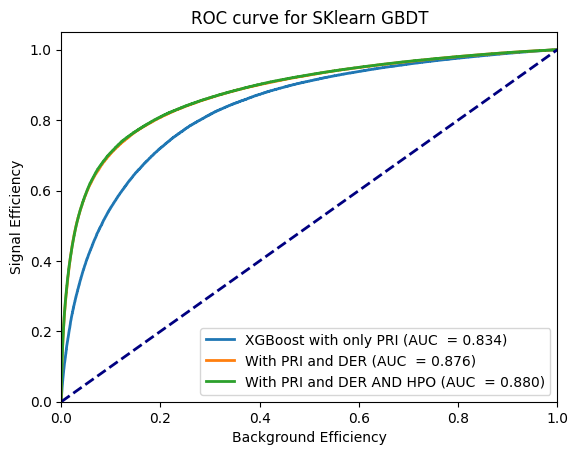

In [ ]:
fpr_skgb,tpr_skgb,roc_score_skgb=roc_curve_plot(skgb,test_set,y_pred_skgb,y_test,valid_weights)
fpr_der_skgb,tpr_der_skgb,roc_score_der_skgb=roc_curve_plot(skgb_der,test_set_der,y_pred_der_skgb,y_test,valid_weights)
fpr_der_hpo_skgb,tpr_der_hpo_skgb,roc_score_der_hpo_skgb=roc_curve_plot(skgb_der_hpo,test_set_der,y_pred_der_hpo_skgb,y_test,valid_weights)
plt.plot(fpr_skgb, tpr_skgb,lw=2, label='XGBoost with only PRI (AUC  = {:.3f})'.format(roc_score_skgb))
plt.plot(fpr_der_xgb, tpr_der_xgb,lw=2, label='With PRI and DER (AUC  = {:.3f})'.format(roc_score_der_skgb))
plt.plot(fpr_der_hpo_xgb, tpr_der_hpo_xgb,lw=2, label='With PRI and DER AND HPO (AUC  = {:.3f})'.format(roc_score_der_hpo_skgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC curve for SKlearn GBDT')
plt.legend(loc="lower right")
plt.show()

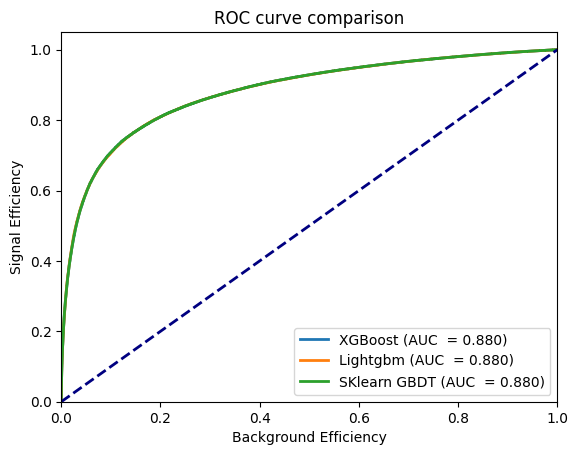

In [ ]:
plt.plot(fpr_der_hpo_xgb, tpr_der_hpo_xgb,lw=2, label='XGBoost (AUC  = {:.3f})'.format(roc_score_der_hpo_xgb))
plt.plot(fpr_der_hpo_lgb, tpr_der_hpo_lgb,lw=2, label='Lightgbm (AUC  = {:.3f})'.format(roc_score_der_hpo_lgb))
plt.plot(fpr_der_hpo_xgb, tpr_der_hpo_xgb,lw=2, label='SKlearn GBDT (AUC  = {:.3f})'.format(roc_score_der_hpo_skgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Efficiency')
plt.ylabel('Signal Efficiency')
plt.title('ROC curve comparison')
plt.legend(loc="lower right")
plt.show()

## Significance Curve

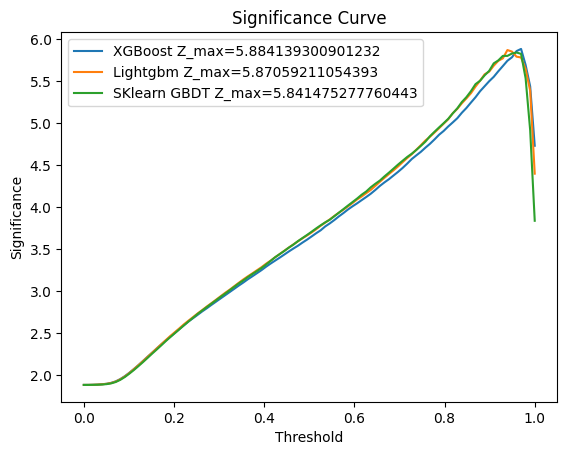

In [ ]:
Z_xgb=significance_vscore(y_test,y_pred_der_hpo_xgb,sample_weight=valid_weights)
Z_lgb=significance_vscore(y_test,y_pred_der_hpo_lgb,sample_weight=valid_weights)
Z_skgb=significance_vscore(y_test,y_pred_der_hpo_skgb,sample_weight=valid_weights)
threshold=np.linspace(0,1,num=len(Z_xgb))
plt.plot(threshold,Z_xgb,label=f'XGBoost Z_max={np.max(Z_xgb)}')
plt.plot(threshold,Z_lgb,label=f'Lightgbm Z_max={np.max(Z_lgb)}')
plt.plot(threshold,Z_skgb,label=f'SKlearn GBDT Z_max={np.max(Z_skgb)}')
plt.xlabel('Threshold')
plt.ylabel('Significance')
plt.title('Significance Curve')
plt.legend()
plt.show()

# Save the best model

In [ ]:
lgb_model_der_hpo.save_model("bdt_lgb")